In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates

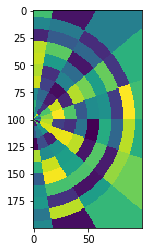

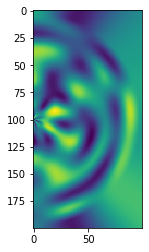

In [4]:
def polar2cartesian(r, t, grid, x, y, order=3):

    X, Y = np.meshgrid(x, y)

    new_r = np.sqrt(X*X+Y*Y)
    new_t = np.arctan2(X, Y)

    ir = interp1d(r, np.arange(len(r)), bounds_error=False)
    it = interp1d(t, np.arange(len(t)))

    new_ir = ir(new_r.ravel())
    new_it = it(new_t.ravel())

    new_ir[new_r.ravel() > r.max()] = len(r)-1
    new_ir[new_r.ravel() < r.min()] = 0

    return map_coordinates(grid, np.array([new_ir, new_it]),
                            order=order).reshape(new_r.shape)

# Define original polar grid

nr = 10
nt = 10

r = np.linspace(1, 100, nr)
t = np.linspace(0., np.pi, nt)
z = np.random.random((nr, nt))

# Define new cartesian grid

nx = 100
ny = 200

x = np.linspace(0., 100., nx)
y = np.linspace(-100., 100., ny)

# Interpolate polar grid to cartesian grid (nearest neighbor)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(polar2cartesian(r, t, z, x, y, order=0), interpolation='nearest')
plt.show()
#fig.savefig('test1.png')

# Interpolate polar grid to cartesian grid (cubic spline)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(polar2cartesian(r, t, z, x, y, order=3), interpolation='nearest')
plt.show()

In [5]:
%time
polar2cartesian(r, t, z, x, y, order=3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


array([[0.69269463, 0.69139747, 0.68759857, ..., 0.52220498, 0.52685857,
        0.53132374],
       [0.69117639, 0.68988984, 0.68612099, ..., 0.52678913, 0.53130154,
        0.53562938],
       [0.68646091, 0.68522602, 0.68160785, ..., 0.53127887, 0.53565112,
        0.53984273],
       ...,
       [0.46623379, 0.46535142, 0.46276858, ..., 0.7723712 , 0.7764717 ,
        0.78030844],
       [0.47129532, 0.4702879 , 0.46734215, ..., 0.76806437, 0.7723927 ,
        0.77645157],
       [0.47314648, 0.47209568, 0.46902666, ..., 0.76357457, 0.76813168,
        0.77241376]])

In [7]:
import scipy.ndimage

def polar2cartesian_orig(outcoords, inputshape, origin):
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))

    return (r,theta_index)

In [14]:
%time
temperature_cartesian = scipy.ndimage.geometric_transform(z, polar2cartesian_orig, 
    order=0,
    output_shape = (z.shape[0] * 2, z.shape[0] * 2),
    extra_keywords = {'inputshape':z.shape,'origin':(z.shape[0], z.shape[0])})

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


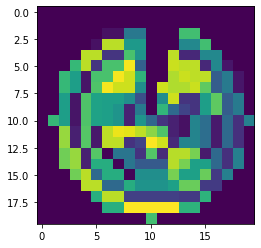

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(temperature_cartesian, interpolation='nearest')
plt.show()

In [6]:
from skimage import data, color, util
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import hog

def task(image):
    """
    Apply some functions and return an image.
    """
    image = denoise_tv_chambolle(image[0][0], weight=0.1, channel_axis=-1)
    fd, hog_image = hog(color.rgb2gray(image), orientations=8,
                        pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                        visualize=True)
    return hog_image


# Prepare images
hubble = data.hubble_deep_field()
width = 10
pics = util.view_as_windows(hubble, (width, hubble.shape[1], hubble.shape[2]), step=width)

In [13]:
def comprehension_loop():
    return [task(image) for image in pics]

%time test2 = comprehension_loop()

CPU times: user 1.46 s, sys: 4.18 ms, total: 1.47 s
Wall time: 1.48 s


In [11]:
from joblib import Parallel, delayed
def joblib_loop():
    results = Parallel(n_jobs=2)(delayed(task)(i) for i in pics)
    return results

%time 
test = joblib_loop()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [15]:
test[0]==test2[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])